Energy Spectrum of Prompt Fission Neutrons
=======================

The energy spectrum of the prompt fission neutrons, which we'll call as the
prompt fission spectrum for simplicity, represents the probability of neutrons
of different energies to be born in a fission event &mdash; a very important
parameter.

This quantity, usually denoted by $\chi_p$, is a probability distribution.
So let's check some simple approaches to it.

In [618]:
import numpy as np
from math import pi, sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sym
from pyne import ace
from sympy.plotting import plot


mpl.style.use('seaborn')

We'll define 2 common distributions used to represent the fission spectrum:
the Maxwell distribution and the Watt distribution.
At fission spectrum energies we are quite far from thermal equilibrium, so both are fittings.
We'll talk just briefly about the modern theory in the end.

The Maxwell distribution **in energy** is of the form:

$ P(E') = \frac{2\pi}{(\pi kT)^{3/2}} \sqrt{E'} \ \mathrm{e}^{\frac{-E'}{kT}} $

For convenience, we can separate the coefficients in such a way:

$ P(E') = c_1 \sqrt{E'} \ \mathrm{e}^{-c_2 E'} $; where:

$ c_1(kT) = \frac{2\pi}{(\pi kT)^{3/2}} $ and $ c_2(kT) = {\frac{1}{kT}} $

In these coefficients $ k $ is the Boltzmann constant and $ T $ is the absolute temperature, however it is convenient to
leave the product $ kT $, which is a measure of temperature in units of energy, because $ T $ itself is unknown, but
$ kT $ is a quantity called "nuclear temperature" (also found as $ T(E) $), which is tabulated for incoming neutron
energies on ENDF files.

We can find the approximate Prompt Fission Neutron Spectrum (PFNS), represented by $ \chi_p(E') $, taking
$ kT = 1.2887 $ MeV, giving a $ c_1 = 0.771 $ and $ c_2 = 0.776 $.

$ \chi_p(E') = 0.771 \sqrt{E'} \ \mathrm{e}^{-0.776E'} $

In [619]:

def maxwell(c1, c2):
    P = c1 * sym.sqrt(Ep) * sym.exp(-c2 * Ep)
    return P

def maxwell_coe(kT):
    c1 = 2*pi / pow(pi*kT, 3/2)
    c2 = 1/kT
    return c1, c2

xmin = 0
xmax = 10
points = 10000000
fig_size = (5,3)

xlabel = "$E'$ (MeV)"
ylabel = "$ \chi_{\mathrm{p}} (\mathrm{MeV}^{-1}) $"

Let's start by checking how the Maxwell distribution does.

Coefficients c1 and c2 are: (0.7713070776425642, 0.775975789555366)


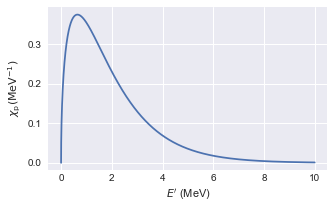

In [620]:
kT = 1.2887 # MeV

print("Coefficients c1 and c2 are:", maxwell_coe(kT))

Ep = sym.symbols('Ep')

maxwell_chi = maxwell(*maxwell_coe(kT))
maxwell_lin = plot(maxwell_chi, (Ep, xmin, xmax),
                   adaptive = False,
                   nb_of_points = points,
                   size= fig_size,
                   xlabel=xlabel,
                   ylabel=ylabel,
                   axis_center=(-0.5,-0.01),
                   show=False)

maxwell_lin.save('chi_maxwell.pdf')

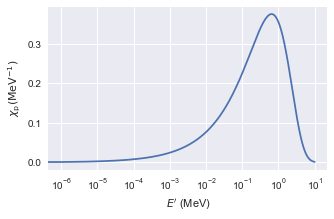

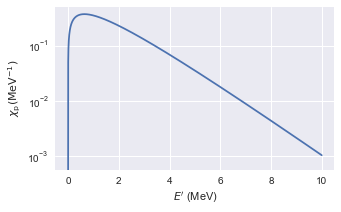

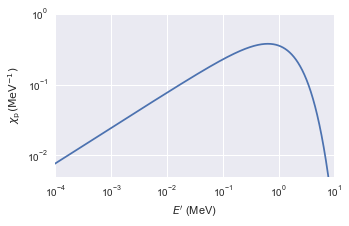

In [621]:
x_maxwellPFNS, y_maxwellPFNS = maxwell_lin._series[0].get_points()

fig1, ax1 = plt.subplots(figsize=fig_size)
# ax1.set_xscale('log')
ax1.semilogx(x_maxwellPFNS, y_maxwellPFNS, label='Maxwell PFNS')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)

plt.savefig('chi_maxwell_logx.pdf', bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=fig_size)
ax2.semilogy(x_maxwellPFNS, y_maxwellPFNS, label='Maxwell PFNS')
ax2.set_xlabel(xlabel)
ax2.set_ylabel(ylabel)

plt.savefig('chi_maxwell_logy.pdf', bbox_inches='tight')

fig3, ax3 = plt.subplots(figsize=fig_size)
ax3.loglog(x_maxwellPFNS, y_maxwellPFNS, label='Maxwell PFNS')
ax3.set_xlabel(xlabel)
ax3.set_ylabel(ylabel)
ax3.set_xlim(1E-4, 10)
ax3.set_ylim(0.005, 1)

plt.savefig('chi_maxwell_logxy.pdf', bbox_inches='tight')

The Maxwell distribution is unimodal (i.e., has only one mode), so when we
calculate the mode, we can simply pick the only value in the list.
We can find this mode as one would expect: take the derivative and solve for the 0s.

In [622]:
def dist_modes(f_x, x):
    fp_x = sym.diff(f_x, x)
    modes = sym.solve(fp_x, x)

    return modes


# modes = dist_modes(maxwell_chi, Ep)
#
# max_Ep = modes[0]
# max_chi = maxwell_chi.subs(Ep, max_Ep)
#
# print('Most probable fission promp neutron energy: ', max_Ep)
# print('With probability of: ', max_chi)

With this, we found that the most probable prompt neutron from fission has
energy of around 0.64 MeV. (at least according to Maxwell)

But for such a skewed distribution, it is quite obvious that the average energy
of the prompt neutrons $ \bar{E'} $ is quite different.
We can find it by calculating the mean of the distribution.

$ \bar{E'} = \frac{\int_{0}^{\infty} E'\  \chi(E') dE'}{\int_{0}^{\infty} \chi(E') dE'} $

In [623]:
def dist_mean(f_x, x):
    interval = (x, 0, sym.oo)

    num = sym.integrate(f_x*x, interval)
    den = sym.integrate(f_x, interval)

    return num / den

mean_Ep = dist_mean(maxwell_chi, Ep)
mean_chi = maxwell_chi.subs(Ep, mean_Ep)

print('Fission promp neutron mean energy: ', mean_Ep)
print('With probability of : ', mean_chi)

Fission promp neutron mean energy:  1.93305000000000
With probability of :  0.239280406306773


So, according to the Maxwellian distribution, the average fission prompt
neutron energy is around 1.93 MeV.
Usually, the value is simply rounded and accepted to be around 2 MeV.

Now let's repeat everything for the Watt distribution and see how it does.
The Watt's distribution is empirical, of the form:

$ \chi_p(E') = c \sinh{\sqrt{b(E)\ E'}} \ \mathrm{e}^{\frac{-E'}{a(E)}} $

where $E$ is the energy of the incoming neutron (the neutron that causes
fission) and $E'$ is the energy of the outgoing prompt fission neutron and
the parameters $ a b c $ are tabulated, and $ a $ seems to represent something
like "nuclear temperature" as in the Maxwellian distribution.

The idea is that it approximates the Maxwellian spectrum corrected for the
transformation from the center-of-mass system to the laboratory system.

We can already expect the Watt function to perform a bit better, if for no
other reason than by having more tuning parameters (assuming that the functions
were well-chosen &mdash; and they were)

In [624]:
def watt_function(c, b, a):
    P = c * sym.sinh(sym.sqrt(b * Ep)) * sym.exp(-Ep/a)
    return P

Fission promp neutron mean energy:  2.00000000000000
With probability of :  0.238794720840315


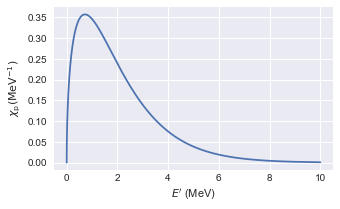

In [625]:
# I actually forgot where I got these, but I know that they are tabulated on ENDF
c = 0.4865
b = 2
a = 1

watt_chi = watt_function(c, b, a)
watt_lin = plot(watt_chi, (Ep, xmin, xmax),
                adaptive = False,
                nb_of_points = points,
                size=fig_size,
                xlabel=xlabel,
                ylabel=ylabel,
                axis_center=(-0.5,-0.01),
                show=False)

watt_lin.save ('chi_watt.pdf')

# modes = dist_modes(watt_chi, Ep)
#
# max_Ep = modes[0]
# max_chi = watt_chi.subs(Ep, max_Ep)

# print('Most probable fission promp neutron energy: ', max_Ep)
# print('With probability of: ', max_chi)

mean_Ep = dist_mean(watt_chi, Ep)
mean_chi = watt_chi.evalf(subs={Ep: mean_Ep})

print('Fission promp neutron mean energy: ', mean_Ep)
print('With probability of : ', mean_chi)

As an empirical formulation, the Watt distribution nails the mean fission prompt
neutron energy at 2 MeV.
Naturally, that happens because the parameters were carefully chosen.

Now let's plot both distributions together to see how they differ qualitatively.

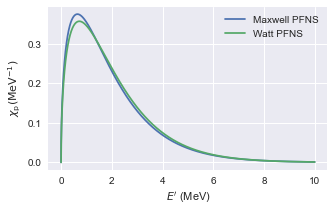

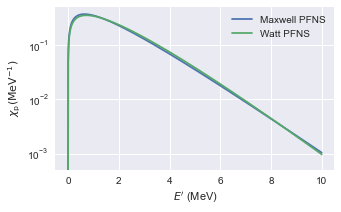

In [626]:
x_wattPFNS, y_wattPFNS = watt_lin._series[0].get_points()

fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x_maxwellPFNS, y_maxwellPFNS, label='Maxwell PFNS')
ax.plot(x_wattPFNS, y_wattPFNS, label='Watt PFNS')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

plt.savefig('maxwell_watt_comparison.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=fig_size)
ax.semilogy(x_maxwellPFNS, y_maxwellPFNS, label='Maxwell PFNS')
ax.plot(x_wattPFNS, y_wattPFNS, label='Watt PFNS')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

plt.savefig('maxwell_watt_comparison_logy.pdf', bbox_inches='tight')

We can also plot using a log scale on the energy axis to investigate emission
of neutrons with lower energy.
The distribution shows that some do appear, but the vast majority is clearly on
the MeV range.
Considering that fission cross-sections become much bigger in the eV range, we
can develop intuitively the idea of moderation.

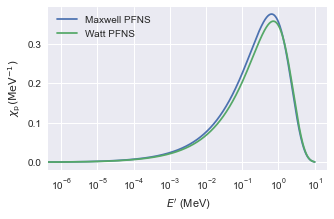

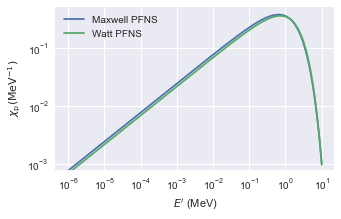

In [627]:
fig, ax = plt.subplots(figsize=fig_size)
ax.set_xscale('log')
ax.plot(x_maxwellPFNS, y_maxwellPFNS, label='Maxwell PFNS')
ax.plot(x_wattPFNS, y_wattPFNS, label='Watt PFNS')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

plt.savefig('maxwell_watt_comparison_logx.pdf', bbox_inches='tight')

ymin = 8E-4

fig, ax = plt.subplots(figsize=fig_size)
ax.loglog(x_maxwellPFNS, y_maxwellPFNS, label='Maxwell PFNS')
ax.plot(x_wattPFNS, y_wattPFNS, label='Watt PFNS')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_ylim(ymin=ymin)

plt.savefig('maxwell_watt_comparison_logxy.pdf', bbox_inches='tight')

The modern take on fission spectrum of prompt neutrons is based on the
Madland-Nix Spectrum.
This model is based on the standard nuclear evaporation theory and utilizes
an isospin-dependent optical potential for the inverse process of compound
nucleus formation in neutron-rich fission fragments.
Quite impressive keywords there you have to admit!
The intention of this elaborate model is to represent the fission products in
full acceleration in the laboratory system in order to get the right spectrum
for the neutrons that evaporate from the primary fission products.

This is enough about fission spectrum for our purposes.
It allows us to know that there are different models available, with different
accuracies and sophistication behind.

But more importantly, now you know that the mean fission neutron energy is
around 2 MeV, so now when we plot some other figures, you know where the
fission neutron is located.

Below, we do even better by plotting the PFNS with the fission cross-section
for U-235, which shows how the overlap between both is minimal.

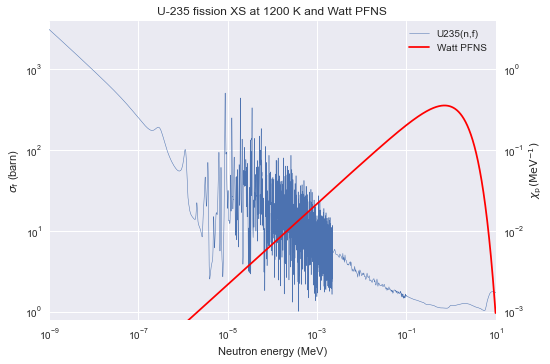

In [634]:
xlims = (1E-9, 10)
ylims = np.array([8E-1, 4E3])

xlabel_xs = 'Neutron energy (MeV)'
ylabel_xs = '$ \sigma_{\mathrm{f}} $ (barn)'

U235 = ace.Library("/Users/rodrigo/opt/Serpent2/xsdata/jeff311/acedata/92235JEF311.ace")
U235.read()
U235_12 = U235.tables['92235.12c']

fig, ax = plt.subplots()
ax.loglog(U235_12.energy, U235_12.reactions[18].sigma,
          linewidth=0.5,
          label='U235(n,f)')
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set(xlabel=xlabel_xs,
       ylabel=ylabel_xs,
       title='U-235 fission XS at 1200 K')

h1, l1 = ax.get_legend_handles_labels()

plt.savefig('U235_1200K_MT18.pdf', bbox_inches='tight')

ax.set(title='U-235 fission XS at 1200 K and Watt PFNS')

ax2 = ax.twinx()
ax2.loglog(x_wattPFNS, y_wattPFNS, color='red', label='Watt PFNS')
ax2.set_ylabel(ylabel)
ax2.set_ylim(*ylims/1E3)
ax2.grid(False)

h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2)

plt.savefig('U235_1200K_MT18_chip.pdf', bbox_inches='tight')

In order to improve the chance of fission, we would like to shift the neutron
spectrum to somewhere on the eV range, which is the idea of adding a moderator
to the reactors.

So we'll check that idea here by studying energy and speed at reactor operating
temperatures.

In [629]:
#From NIST in 14/2/2022
k_B = 8.617333262E-5 # eV/K
kB_J = 1.380649E-23 # J/K

neutron_mass = 1.67492749804E-27 # kg
eV2Joule = 1.602176565E-19

def E_mean(T):
    return 3/2 * k_B * T

def particle_speed(m, E):
    return sqrt(2*E/m)

def report_neutron_data(T):
    E = T*k_B
    v = particle_speed(neutron_mass, E*eV2Joule)
    print(f"{T} K represents", E, "eV")
    print(f"Neutron speed", v, "m/s")

    Em = E_mean(T)
    vm = particle_speed(neutron_mass, Em*eV2Joule)
    print(f"Mean energy", Em, "eV")
    print(f"Mean speed:", vm, "m/s\n")

# test energy and idea
report_neutron_data(300)
report_neutron_data(600)

300 K represents 0.025851999786 eV
Neutron speed 2223.920462567311 m/s
Mean energy 0.038777999679 eV
Mean speed: 2723.735180912124 m/s

600 K represents 0.051703999572 eV
Neutron speed 3145.098479801738 m/s
Mean energy 0.077555999358 eV
Mean speed: 3851.9432331586618 m/s



So we can see that with a moderator at 300 K (+- room temperature) we have a neutron
energy of just around 0.025 eV, which intuitively already looks promising if we look
at the cross-section values.

But we can reach better conclusions by plotting the Maxwellian spectrum at this
temperature and see what happens. Unlikk when we wanted to calculate the PFNS, which
required a tabulated "nuclear temperature", here we can calculate everything from the
desired temperature.

Coefficients c1 and c2 at 300 K: (271.46499994684825, 38.68172707248528)
Coefficients c1 and c2 at 600 K: (95.97737115861109, 19.34086353624264)


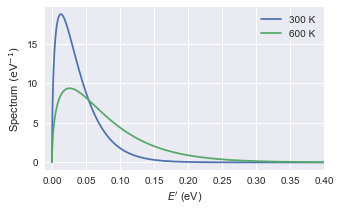

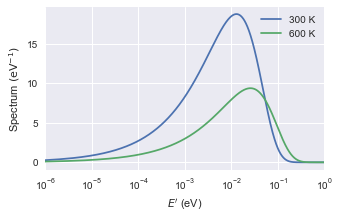

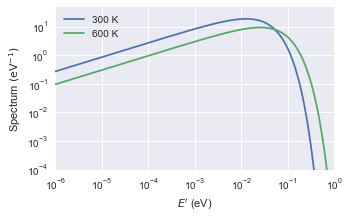

In [630]:
T1 = 300
T2 = 600 # reactor coolant temperature in K

kT1_thermal = T1*k_B # eV
kT2_thermal = T2*k_B

print(f"Coefficients c1 and c2 at {T1} K:", maxwell_coe(kT1_thermal))
print(f"Coefficients c1 and c2 at {T2} K:", maxwell_coe(kT2_thermal))
maxwell_T1 = maxwell(*maxwell_coe(kT1_thermal))
maxwell_T2 = maxwell(*maxwell_coe(kT2_thermal))

xlabel_thermal = "$E'$ (eV)"
ylabel_thermal = "Spectrum $(\mathrm{eV}^{-1})$"
maxwell_T_lin = plot(maxwell_T1, maxwell_T2, (Ep, 1E-9, 1),
                     adaptive = False,
                     nb_of_points = 1000000,
                     size= fig_size,
                     xlabel=xlabel_thermal,
                     ylabel=ylabel_thermal,
                     axis_center=(-0.04,-0.3),
                     show=False)

x_maxwellT1, y_maxwellT1 = maxwell_T_lin._series[0].get_points()
x_maxwellT2, y_maxwellT2 = maxwell_T_lin._series[1].get_points()

fig, ax = plt.subplots(figsize=fig_size)
ax.plot(x_maxwellT1, y_maxwellT1, label=f'{T1} K')
ax.plot(x_maxwellT2, y_maxwellT2, label=f'{T2} K')
ax.set_xlabel(xlabel_thermal)
ax.set_ylabel(ylabel_thermal)
ax.set_xlim(-0.01, 0.4)
ax.legend()

plt.savefig('maxwell_thermal.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=fig_size)
ax.semilogx(x_maxwellT1, y_maxwellT1, label=f'{T1} K')
ax.semilogx(x_maxwellT2, y_maxwellT2, label=f'{T2} K')
ax.set_xlabel(xlabel_thermal)
ax.set_ylabel(ylabel_thermal)
ax.set_xlim(1E-6, 1)
ax.legend()

plt.savefig('maxwell_thermal_logx.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=fig_size)
ax.loglog(x_maxwellT1, y_maxwellT1, label=f'{T1} K')
ax.loglog(x_maxwellT2, y_maxwellT2, label=f'{T2} K')
ax.set_xlabel(xlabel_thermal)
ax.set_ylabel(ylabel_thermal)
ax.set_xlim(1E-6, 1)
ax.set_ylim(1E-4, 50)
ax.legend()

plt.savefig('maxwell_thermal_logxy.pdf', bbox_inches='tight')

The distributions appear to be in the right place. We can put that together with
the fission cross-section and PFNS and observe that we shifted the spectrum to
the left of the resonance range.

This is much better from the point of view of maximizing fission as long as we can
achieve that effectively, which means that we have to reduce the neutron energy as
fast as possible to avoid the resonance range that is in between the PFNS and the
Maxwellian distributions.

In [631]:
x_maxwellT1 = x_maxwellT1*10E-6 # shift x from eV to MeV
x_maxwellT2 = x_maxwellT2*10E-6

y_maxwellT1 = y_maxwellT1/10E-6 # shift x from eV to MeV
y_maxwellT2 = y_maxwellT2/10E-6

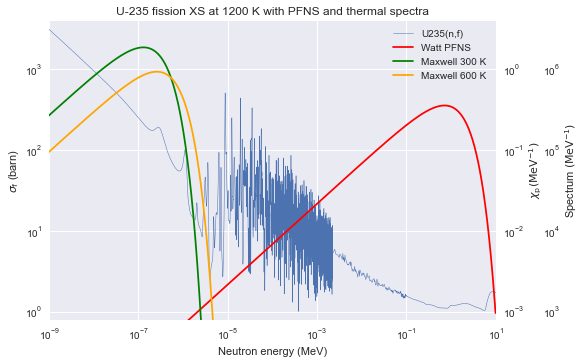

In [632]:
fig, ax = plt.subplots()
ax.loglog(U235_12.energy, U235_12.reactions[18].sigma,
          linewidth=0.5,
          label='U235(n,f)')

ax.set(xlabel='Neutron energy (MeV)',
       ylabel='$ \sigma_{\mathrm{f}} $ (barn)',
       title='U-235 fission XS at 1200 K with PFNS and thermal spectra')
ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
h1, l1 = ax.get_legend_handles_labels()

ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel(ylabel)
ax2.set_ylim(*ylims/1E3)
ax2.loglog(x_wattPFNS, y_wattPFNS, color='red', label='Watt PFNS')

h2, l2 = ax2.get_legend_handles_labels()

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 40))
ax3.grid(False)
ax3.set_ylabel("Spectrum $(\mathrm{MeV}^{-1})$")
ax3.set_ylim(*ylims*1E3)
ax3.loglog(x_maxwellT1, y_maxwellT1, color='green', label=f'Maxwell {T1} K')

h3, l3 = ax3.get_legend_handles_labels()
plt.legend(h1+h2+h3, l1+l2+l3)

plt.savefig('U235_1200K_MT18_chip_maxwellT1.pdf', bbox_inches='tight')

ax3.loglog(x_maxwellT2, y_maxwellT2, color='orange', label=f'Maxwell {T2} K')
h3, l3 = ax3.get_legend_handles_labels()
plt.legend(h1+h2+h3, l1+l2+l3)

plt.savefig('U235_1200K_MT18_chip_maxwellT12.pdf', bbox_inches='tight')